# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Trabajo Práctico N°4
## Procesamiento de arreglos
En este trabajo se presenta un análisis de señales espaciales obtenidas de una base de datos conocida como *CMU Microphone Array Database*, aplicando conocimientos, métodos y técnicas del procesamiento de arreglos.

### Grupo N°1
* Davidov, Gonzalo Joaquín
* Farall, Facundo David
* Kammann, Lucas Agustín
* Trozzo, Rafael Nicolás

In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

In [3]:
from scipy import signal

In [4]:
import numpy as np

In [5]:
import IPython

# 1. Mediciones del arreglo

## 1.1. Leyendo las mediciones

In [6]:
dataset_filename = '../resource/mtms-arrC1A.wav'   # Filepath of the WAV file
fs, data_samples = wavfile.read(dataset_filename)  # Read the samples and the sampling frequency of the WAV file
data_samples = np.swapaxes(data_samples, 0, 1)     # Swap axes of channels and time instant
data_samples = data_samples / data_samples.max()   # Normalize the amplitude
M, N = data_samples.shape                          # Extract the shape of the samples container

In [7]:
IPython.display.Audio(data_samples[0:2], rate=fs)  # Play the recorded sound, take first two sensors

In [8]:
print(f'El arreglo cuenta con {M} sensores y se tienen {N} muestras grabadas a {fs / 1e3}kHz')

El arreglo cuenta con 15 sensores y se tienen 543489 muestras grabadas a 16.0kHz


In [9]:
arrays_indexes = [           # Create an array with indexes used to extract microphone sub-arrays
    [3,4,5,6,7,8,9,10,11],   # First ULA sub-array
    [1,2,3,5,7,9,11,12,13],  # Second ULA sub-array
    [0,1,3,7,11,13,14]       # Third ULA sub-array
]
arrays_spacing = [4, 8, 16]  # Spatial distance between sensors in each sub-array expressed in centimeters

In [10]:
sub_array_samples = [ data_samples[indexes] for indexes in arrays_indexes ] # Create samples for each sub-array case

## 1.2 Demodulación y filtrado para la obtención de $\vec{x}(n)$
La base del funcionamiento del procesamiento de arreglos es la diferencia de fase que presenta la señal en cada uno de los sensores del arreglo. Esta diferencia de fase se debe a la diferencia de tiempos de propagación en el arribo de la señal a cada sensor, debido la dirección en la que viaja la señal espacial. No obstante, esa diferencia de fase puede cambiar con la frecuencia temporal de la señal. Esto es un inconveniente, porque no bastaría con conocer la información de fase para determinar la dirección en que se propagó la señal, y para solucionarlo se busca (idealmente) trabajar con señales de una única frecuencia. 

Llevando esto al caso práctico que se está analizando acá, las señales de audio obtenidas con los micrófonos fueron muestreadas con una frecuencia $f_s = 16kHz$, por ende, el ancho de banda máximo será $f_{max} = 8kHz$. La voz del ser humano, no obstante, suele considerarse limitada en $f \in [100 Hz, 7 kHz]$. En estas condiciones no es posible aplicar de forma directa procesamiento de arreglos sobre la información capturada por los micrófonos del arreglo lineal, porque con un espectro de frecuencias de ese ancho de banda no se podría desambiguar la dirección de la fuente siendo que varía la frecuencia de la señal. Para solucionar esto, se busca cumplir con la condición narrowband, esto quiere decir que se trabaja con un espectro que se encuentra centrado en una frecuencia central denominada *portadora*, con un ancho de banda pequeño en relación con tal portadora. De esta forma, la variación relativa de frecuencia no produce un cambio significativo de la fase, y puede asociarse un cambio de fase a un cambio de dirección de propagación.

Si se sigue esta estrategia, resulta que la señal que se busca procesar es una señal pasabanda, pero el procesamiento es más eficiente para señales de banda base. Entonces, se busca aplicar una demodulación (para llevar el espectro centrado en la frecuencia portadora a estar centrado en el origen), y luego aplicar un filtro pasabajos con el cual se remueva todo lo que se encuentra por fuera de ese ancho de banda suficientemente pequeño para garantizar la condición narrowband. Nada garantiza que la señal de voz humano debe ser simétrica con respecto a una frecuencia arbitraria (según dónde apliquemos el procesamiento), por ende luego de la demodulación se obtendrá una señal compleja (dado que las señales reales poseen un espectro par).

En la línea de lo que se viene explicando, se decide ahora estudiar el caso de una frecuencia portadora $f_c = 2kHz$. Para aplicar la demodulación y el filtrado, es necesario determinar qué sub-arreglo se utilizará. En primer lugar, los diferentes sub-arreglos poseen una distancia entre sensores distinta, lo cual cambia la frecuencia de muestreo espacial. Analizando la condición de Nyquist espacial, y considerando que la velocidad del sonido se puede aproximar como $v = 343 \frac{m}{s}$ en condiciones normales de presión y temperatura (CNPT),

$$d \leq \frac{\\lambda}{2} = \frac{v}{2 \cdot f} \leftrightarrow f \leq \frac{v}{2 \cdot d}$$

Así,

$$d = 4 cm \rightarrow f \leq 4287,5 Hz$$
$$d = 8 cm \rightarrow f \leq 2143,75 Hz$$
$$d = 16 cm \rightarrow f \leq 1071,875 Hz$$

El espaciado $d = 16 cm$ no se puede utilizar porque se produciría aliasing, y es algo que buscamos evitar. Por otro lado, si bien se puede utilizar tanto la opción de $4 cm$ como de $8 cm$, utilizar la de menor tamaño provocaría que se pierda resolución espacial para frecuencias temporales bajas. Esto se debe a que a menor distancia, el rango de espectro espacial que se puede medir por la condición de Nyquist espacial es mayor, y, por ende, si con una frecuencia temporal baja tendríamos una longitud de onda mayor, luego la resolución del rango medible de frecuencias espaciales se ve reducida. Siendo que ambas opciones satisfacen la condición de Nyquist espacial, nos quedamos con aquella que ofrece mayor resolución, es decir, usamos el sub-arreglo con espaciado $d = 8 cm$.

Para determinar el ancho de banda $B$, en primer lugar, es necesario tener presente que con el sub-arreglo seleccionado como la frecuencia máxima es $f_{max} = 2143,75 Hz$, y la portadora que se está analizando es $f_c = 2 kHz$, luego el ancho de banda debe cumplir $B < 287,5 Hz$ para evitar nuevamente el aliasing. Luego, determinar qué valor utilizar por debajo de esa cota se reduce a una relación de compromiso entre cuánta energía se usa (y por ende querríamos aumentar B) y cuánta confusión queremos evitar en las frecuencias espaciales (y por ende querríamos disminuir B). En este caso, el sub-arreglo a utilizar es de 9 elementos, lo cual quiere decir que se puede conseguir una resolución espacial de 20°, por ende no tiene sentido preocuparse excesivamente por la confusión, y podemos permitirnos aumentar la energía dentro de ese margen de frecuencias. Por esto, elegimos utilizar un $B = 100 Hz$ de la frecuencia de portado.

In [11]:
def get_beamformer_input(array_samples, fs, fc, B):
    """ Applies the demodulation and lowpass filtering needed to preprocess
        the beamformer input data.
        @param array_samples Vector of sensor samples
        @param fs Sampling frequency
        @param fc Carrier frequency
        @param B Bandwidth
    """
    M, N = array_samples.shape
    demodulated_samples = array_samples * np.exp(2j * np.pi * fc / fs * np.arange(N)) # Demodulate the array signals
    order = int(2 * fs / B)                                                           # Calculate the FIR order
    window = signal.windows.hamming(order)                                            # Generate the FIR filter based on the Hamming window
    window /= window.sum()                                                            # Normalize the passband attenuation
    filtered_samples = signal.lfilter(window, [1.0], demodulated_samples, axis=1)     # Lowpass filtering
    return window, demodulated_samples, filtered_samples

In [12]:
def plot_frequency_response(h, fs, title):
    """ Plot the frequency response of the FIR filter.
        @param h FIR filter coefficients
        @param fs Sampling frequency
        @param title Title of the plot
    """
    f, H = signal.freqz(h, fs=fs, worN=16384)
    plt.figure(figsize=(14, 6))
    plt.semilogx(f, 20*np.log10(np.abs(H)), label=title)
    plt.legend(fontsize=14)
    plt.xlabel(f'f [Hz]', fontsize=14)
    plt.ylabel('|H(f)| [dB]', fontsize=14)
    plt.grid()
    plt.show()

Para aplicar un filtro pasabajos sobre la señal demodulada se busca utilizar un filtro FIR diseñado con la ventana de Hamming, de la cual se sabe que en el espectro su lóbulo principal ocupa un ancho de banda normalizado de aproximadamente $B_N = \frac{2}{N}$ siendo N el tamaño de la ventana. Para esta aproximación se considera el ancho hasta el cruce por cero del lóbulo principal. Se plantea la siguiente ecuación para determinar el tamaño del filtro,

$$B_N = \frac{2}{N} = \frac{B}{f_s}$$

Reemplazando numéricamente,

$$N = \frac{2 \cdot f_s}{B} = \frac{2 \cdot 16 kHz}{100 Hz} = 320$$

In [13]:
fc = 2e3

In [14]:
B = 100

In [15]:
window, demodulated, filtered = get_beamformer_input(sub_array_samples[1], fs, fc, B)

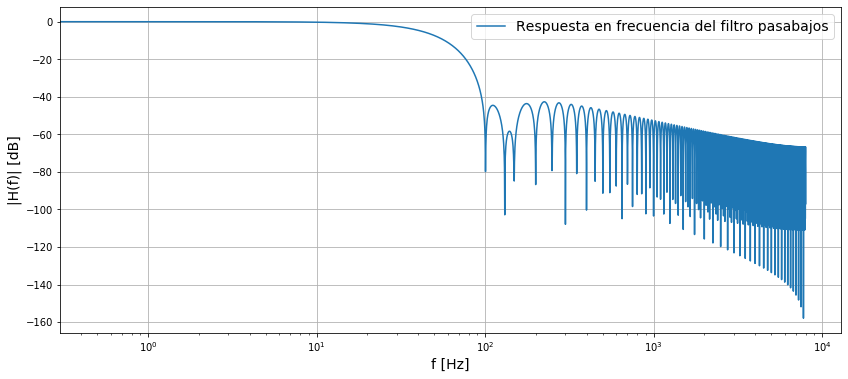

In [16]:
plot_frequency_response(window, fs, 'Respuesta en frecuencia del filtro pasabajos')

## 1.3. Análisis espectral
Para el análisis espectral se calcula el espectro de potencia de las señales demoduladas y filtradas con un pasabajos en diferentes condiciones e instantes del tiempo

In [17]:
def plot_spatial_spectrogram(x, tmin, tmax, fs, title, vmin=None, vmax=None, vclip=1e-11, logarithmic=False):
    """ Plot the spatial spectrogram
        @param x Matrix of sensor samples over time
        @param tmin Initial time of the window
        @param tmax Final time of the window
        @param fs Sampling frequency
        @param title Title of the plot
        @param vmin Minimum value of the spectrogram to be displayed
        @param vmax Maximum value of the spectrogram to be displayed
    """
    spectrum = np.fft.fftshift(np.fft.fft(x, axis=0))
    if logarithmic:
        processed_spectrum = np.log10(vclip + np.abs(spectrum[:,int(tmin * fs):int(tmax * fs)])**2)
    else:
        processed_spectrum = vclip + np.abs(spectrum[:,int(tmin * fs):int(tmax * fs)])**2
    plt.figure(figsize=(20, 5))
    if vmin is None or vmax is None:
        plt.imshow(processed_spectrum, aspect='auto', extent=[tmin, tmax, -90, 90])
    else:
        plt.imshow(processed_spectrum, aspect='auto', extent=[tmin, tmax, -90, 90], vmin=vmin, vmax=vmax)
    u = np.linspace(-0.08/0.1715, 0.08/0.1715, num=9)
    phi = (np.arcsin(0.1715 * u / 0.08) * 360) / (2 * np.pi)
    ax = plt.gca()
    ax.set_yticks(phi)
    plt.title(title, fontsize=15)
    plt.colorbar()
    plt.ylabel('$ \Phi_S $', fontsize=14)
    plt.xlabel('$t$ [s]', fontsize=14)

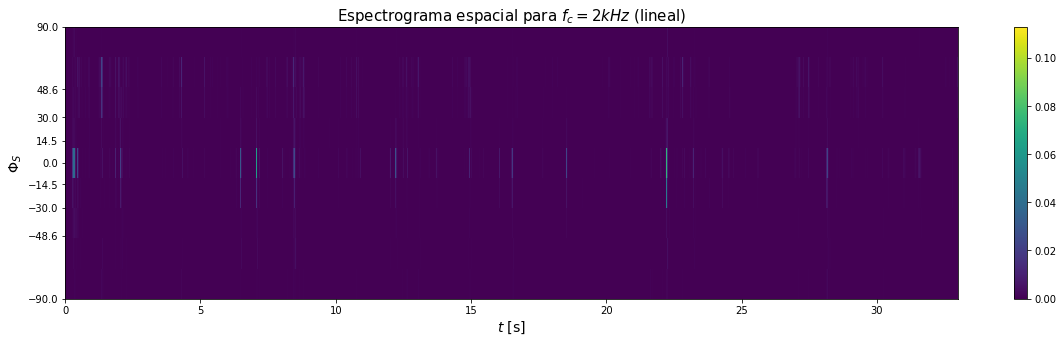

In [18]:
plot_spatial_spectrogram(filtered, 0, 33, fs, 'Espectrograma espacial para $f_c = 2 kHz$ (lineal)')

En este primer gráfico, con escala lineal, se ve una presencia poco visible en la línea de los 0° y 48,6°. Probamos ahora utilizando una escala logarítmica para aprovechar mejor el rango numérico para visualizar mejor aquello con magnitudes poco significativas.

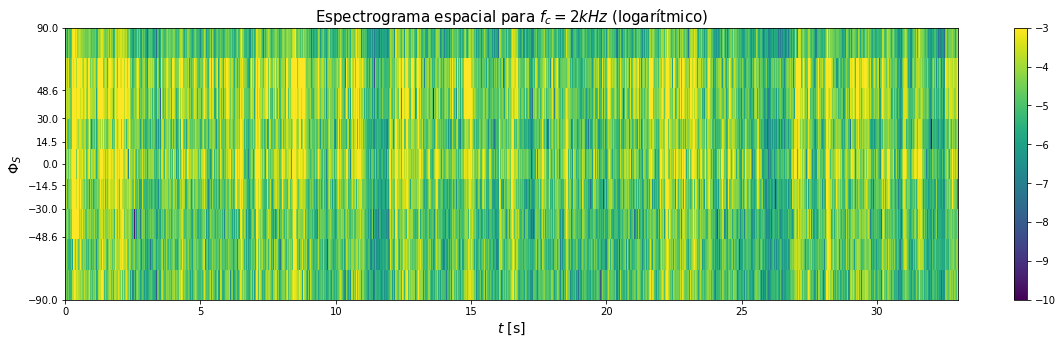

In [19]:
plot_spatial_spectrogram(filtered, 0, 33, fs, 'Espectrograma espacial para $f_c = 2 kHz$ (logarítmico)', logarithmic=True, vmin=-10, vmax=-3)

En este segundo gráfico, notamos que hay a lo largo del tiempo líneas verticales que representan fuentes de sonido en todas las direcciones en las que puede escuchar el arreglo de micrófonos. Esto puede deberse a que las grabaciones fueron tomadas dentro de una sala en donde hay una interferencia (radio) y una señal de interés (persona hablando), y esos sonidos pueden estar produciendo ecos, rebotes o reverberaciones en las paredes de la sala, provocando que el arreglo de micrófonos reciba señales indirectas provenientes de todas las direcciones, aunque con magnitudes mucho menores.

Por otro lado, si bien la presencia de línea verticales impide ver con claridad, se puede notar una presencia más intensa de potencia en 0° y alrededor de 50°.

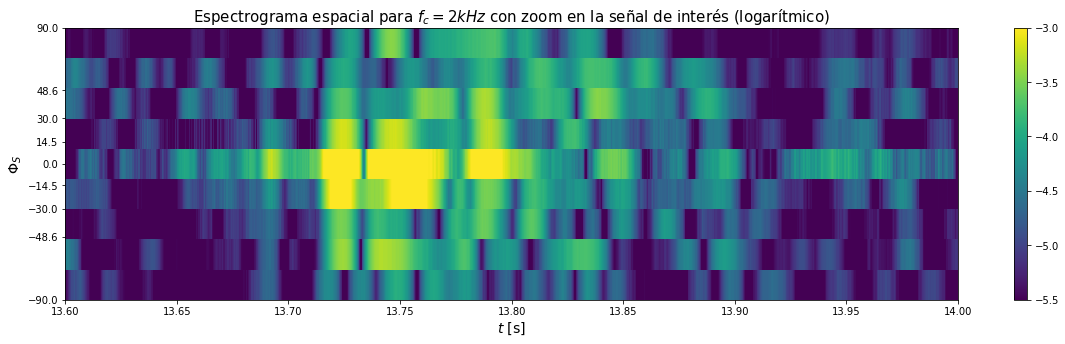

In [20]:
plot_spatial_spectrogram(filtered, 13.6, 14, fs, 'Espectrograma espacial para $f_c = 2 kHz$ con zoom en la señal de interés (logarítmico)', logarithmic=True, vmin=-5.5, vmax=-3)

Para este gráfico, usando escala logarítmica se ajustaron los límites y se busco una región donde sólo hubiera presencia predominante de la señal espacial en la dirección de 0°. Escuchando el siguiente audio en este rango de tiempo, se pudo determinar que se trata de la señal de interés, es decir, la persona hablando.

In [21]:
IPython.display.Audio(data_samples[0:2,int(13.6 * fs):int(14 * fs)], rate=fs)

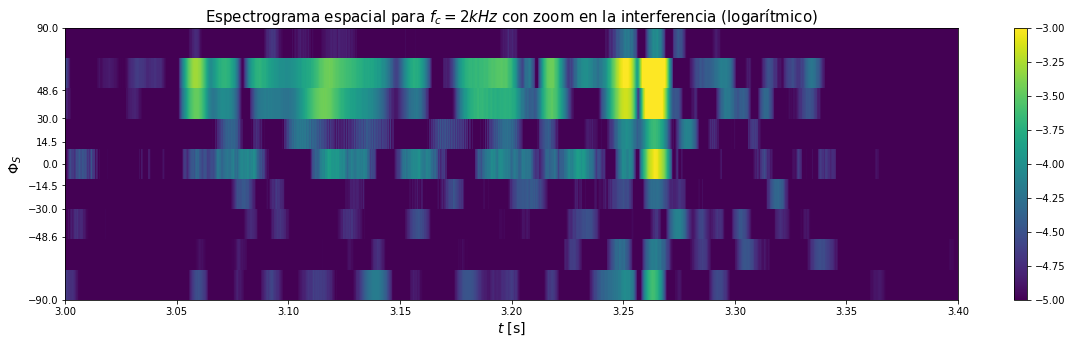

In [22]:
plot_spatial_spectrogram(filtered, 3.0, 3.4, fs, 'Espectrograma espacial para $f_c = 2 kHz$ con zoom en la interferencia (logarítmico)', logarithmic=True, vmin=-5, vmax=-3)

Para este gráfico, usando escala logarítmica se ajustaron los límites y se busco una región donde sólo hubiera presencia predominante de la señal espacial en la dirección de 48,6°. Escuchando el siguiente audio en este rango de tiempo, se pudo determianr que se trata de la señal de interferencia, es decir, la radio.

In [23]:
IPython.display.Audio(data_samples[0:2,int(3.0 * fs):int(3.4 * fs)], rate=fs)

En conclusión, la información recibida cuenta con la presencia de una señal de interés (persona hablando) ubicada en una dirección $\Phi = 0°$ respecto del arreglo de micrófonos, una señal de interferencia (radio) ubicada en una dirección $\Phi = 48,6°$ respecto del arreglo de micrófonos y, además, hay presencia de ecos, rebotes, reverberaciones producidas por las características acústicas del lugar en que se llevaron a cabo las grabaciones. Es importante aclarar que las direcciones de las señales espaciales son estimaciones limitadas por la resolución del arreglo.

# 2. Estimación del beamformer óptimo SMI
En este apartado se selecciona un intervalo donde hay solo interferencia y ruido para poder analizar de donde proviene.


Para la elección de $\alpha$ imponemos la condición de ganancia unitaria en la dirección de observación:

\begin{equation}
    \alpha = \frac{1}{\textbf{v}^H(\phi_s) \hat{\textbf{R}}^{-1}_{i+n} \textbf{v}(\phi_s)}
\end{equation}

Luego el beamformer óptimo es:

\begin{equation}
    \textbf{c}_{smi} = \frac{\hat{\textbf{R}}^{-1}_{i+n} \textbf{v}(\phi_s)}{\textbf{v}^H(\phi_s) \hat{\textbf{R}}^{-1}_{i+n} \textbf{v}(\phi_s)}
\end{equation}


In [24]:
def plot_spatial_response(cs, title, labels=None, default_figsize=True):
    """ Plots the spatial amplitude response of a given filter or signal
        @param c      beamformers coefficients
        @param title  Plot title
    """
    N = len(cs)
    
    if default_figsize:
        plt.figure(figsize=(14,6))
    else:
        plt.figure()
    plt.title(title, fontsize=16)
        
    for k in range(N):
        u, C = signal.freqz(cs[k], whole=True, include_nyquist=True)

    
        C = np.fft.fftshift(C)
        
        C /= np.sqrt(len(cs[k]))

        angle = np.arcsin(2 * (u-np.pi) / (2*np.pi)) * 180 / np.pi
        plt.plot( angle, 20*np.log10(np.abs(C)), label=labels[k] if labels is not None else None)
        plt.xlabel(f'$\phi_s$ [deg]', fontsize=14)
        plt.ylabel('Amplitud [dB]', fontsize=14)

    plt.grid()
    if labels is not None:
        plt.legend(fontsize=15)
    plt.show()

In [25]:
def estimate_Rin(samples):
    """ Estimates R I+N with a maximum likelihood estimator
        @param samples Interference + Noise samples
    """
    R_i_n = 0
    for nk in range(K):
        R_i_n += np.dot(samples[:,nk].reshape(9,1), np.conj(samples[:,nk].reshape(9,1).T))

    R_i_n = R_i_n / K
    
    return R_i_n

In [26]:
def get_array_response_vector(phi_s, fc, B, d, v, M):
    wavelen = v / fc
    u = d * np.sin(phi_s) / wavelen
    v_phi = (1 / np.sqrt(M) * np.exp(-2j*np.pi*u*np.arange(M))).reshape(M, 1)

    return v_phi

In [27]:
def get_beamformer_smi(ni_samples, phi_s, fs, fc, B, d, v):
    """ Calculates the optimal beamformer using Sample Matrix
        Inversion for the given direction and interference+noise
        samples.
        @param ni_samples Interference and noise samples
        @param phi_s      Listening direction
        @param fs         Sampling frequency
        @param fc         Carrier frequency
        @param B          Bandwidth
        @param d          Array sensor spacing in meters
        @param v          Wave propagation velocity
    """
    
    M, K = ni_samples.shape
    
    _, _, filtered_samples = get_beamformer_input(ni_samples, fs, fc, B)

    # Estimate R_i+n
    R_i_n = estimate_Rin(filtered_samples)
    
    v_phi = get_array_response_vector(phi_s, fc, B, d, v, M)
    
    # Compute SMI beamformer
    Rinv = np.linalg.inv(R_i_n)
    alpha = 1 / (np.conj(v_phi.T) @ Rinv @ v_phi)
    csmi = alpha * Rinv @ v_phi

    return R_i_n, csmi, filtered_samples

In [34]:
d = arrays_spacing[array_index]
v = 343 # m/s

In [29]:
array_index = 1
to = 10.1    # seconds 
K = int(1 * fs)
no = int(to * fs)
nlast = int(no + K)
silence = sub_array_samples[array_index][:,no:nlast]

In [30]:
# Play the sound to check there is no voice
IPython.display.Audio(silence[0:1], rate=fs)

In [36]:
R_i_n, csmi, filtered_samples = get_beamformer_smi(silence, phi_s=0, fs=fs, fc=2e3, B=50, d=d, v=v)

La estimación de la matriz de autocorrelación de interferencia + ruido $\hat{R}_{i+n}$ nos permite, al igual que en el caso de la autocorrelación en el tiempo, obtener su espectro de potencia mediante la FFT de la primera fila, que contiene $\hat{r}_{i+n}$

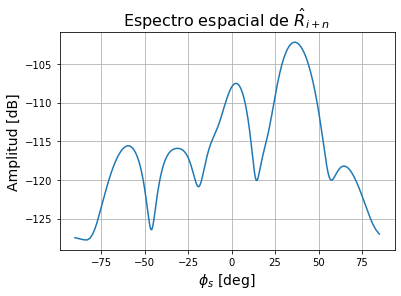

In [37]:
plot_spatial_response([ R_i_n[0,:] ], 'Espectro espacial de $\hat{R}_{i+n}$', default_figsize=False)

Podemos observar que la estimación de la señal de interferencia más ruido tiene un pico alrededor de 35°. Esto es cercano a lo observado en el espectrograma espacial de la sección anterior, donde las principales componentes de dirección estaban entre 30° y 65°. Además se debe tener en cuenta que con 9 sensores la resolución espacial es baja, de aproximadamente 20°, aunque no linealmente distribuida por la transformación entre ángulo $\phi_s$ y frecuencia espacial $u$.

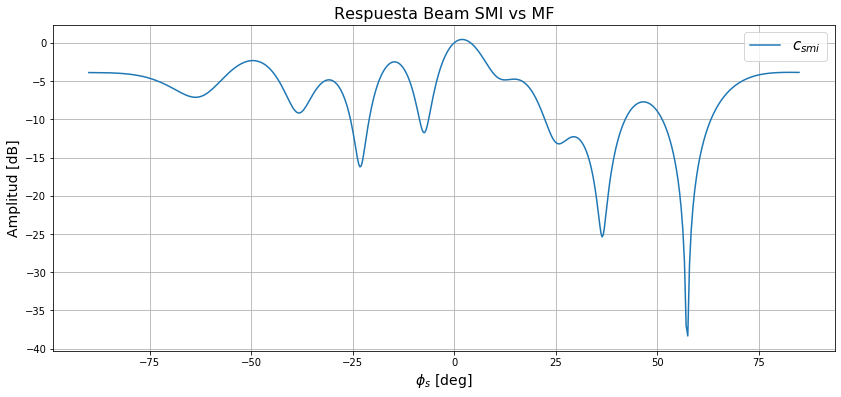

In [38]:
# Plot the beam response
plot_spatial_response([csmi], 'Respuesta Beam SMI vs MF', ['$c_{smi}$'])

In [41]:
_, _, beamf_input = get_beamformer_input(sub_array_samples[array_index], fs, fc, 50)
spatially_filtered = signal.lfilter(csmi.reshape(9), [1.0], beamf_input, axis=0)

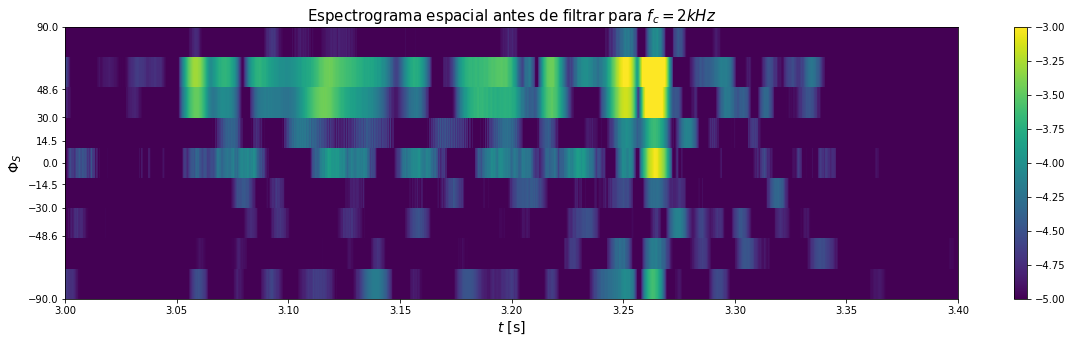

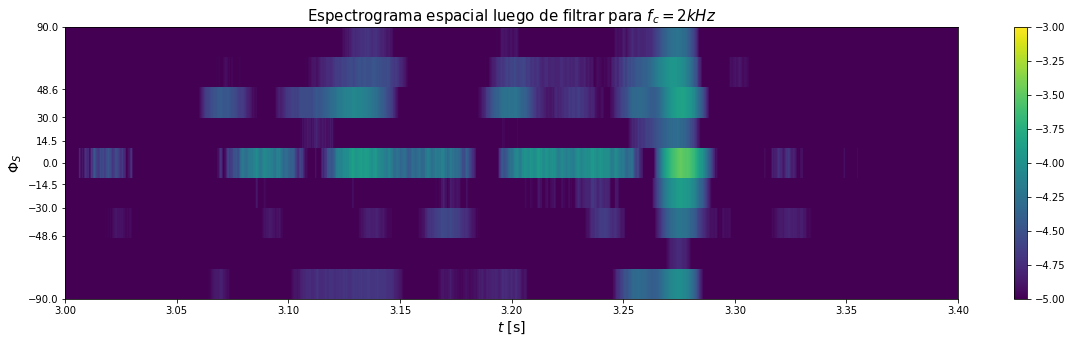

In [42]:
plot_spatial_spectrogram(filtered, 3.0, 3.4, fs, 'Espectrograma espacial antes de filtrar para $f_c = 2 kHz$', logarithmic=True, vmin=-5, vmax=-3)
plot_spatial_spectrogram(spatially_filtered, 3.0, 3.4, fs, 'Espectrograma espacial luego de filtrar para $f_c = 2 kHz$', logarithmic=True, vmin=-5, vmax=-3)

Observamos el resultado del filtrado para un fragmento que solo contiene interferencia, vemos que las commponentes entre 30° y 65° fueron muy atenuadas por el beamformer.